In [1]:
import xml.etree.ElementTree as ET
import numpy as np
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import pandas as pd
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torchvision
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

%matplotlib inline

In [2]:
def smallest_size(bbox):
    bbox = np.array(bbox)
    x1 = min(bbox[:, 0])
    y1 = min(bbox[:, 1])
    x2 = max(bbox[:, 2])
    y2 = max(bbox[:, 3]) 
    
    size = [x1, y1, x2, y2]   
    
    return  size

In [3]:
def parse_rec(filename):
    """Parse a PASCAL VOC xml file."""
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                              int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text),
                              int(bbox.find('ymax').text)]
        objects.append(obj_struct)
        
    bbox = []
    names = set()
    for i in objects:
        bbox.append(i['bbox'])
        names.add(i['name'])
    size = smallest_size(bbox)

    return size, names

In [248]:
def iou(boxA, boxB):
    # 计算两组bbox的IOU
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

    # compute the area of both the prediction and ground-truthles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)

    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou

In [4]:
names = ('wawacai', 'qingjiao', 'shanyao', 'shengjiang', 'maodou', 'xiaomijiao', 'yumi', 'cong',
'tudou', 'xiaomaoli', 'xilanhua', 'lusun', 'qingcai', 'jinzhengu', 'huanggua', 'yundou', 'shengcai',
'caijiao', 'dasuantou', 'hongshu', 'xihongshi', 'huluobo', 'yangcong', 'baiyugu', 'xianggu')

In [250]:
def new_label():
    xml_name = '/home/zufall/sucai_label/VOCdevkit/VOC2018-2/Annotations/{}.xml'
    with open('../VOCdevkit/VOC2018-2/ImageSets/Main/val.set', 'r') as f:
        lines = [i.strip() for i in f.readlines()]
        for i in lines:
            try:
                size, labels = parse_rec(xml_name.format(i))
                if set(names) > set(labels):
                    with open('labels/{}.txt'.format(i), 'w') as txt:
                        txt.writelines(' '.join(map(str, size)) + " ")
                        for label in labels:
                            txt.writelines(str(names.index(label)) + " ")
                    with open('Main/val.txt', 'a') as val:
                        val.writelines(i + '\n')
                else:
                    print(i)
            except:
                pass

In [251]:
def show_image():
    xml_name = '/home/zufall/sucai_label/VOCdevkit/VOC2018-2/Annotations/{}.xml'
    jpg_name = '/home/zufall/sucai_label/VOCdevkit/VOC2018-2/JPEGImages/{}.jpg'
    with open('Main/train.txt', 'r') as f:
        lines = [i.strip() for i in f.readlines()]
        for i in lines[100:104]:
            size, labels = parse_rec(xml_name.format(i))
            image = Image.open(jpg_name.format(i)).convert('RGB')
            plt.figure()
            plt.imshow(image.crop([size[0], size[1], size[2], size[3]]))
            plt.axis('off')

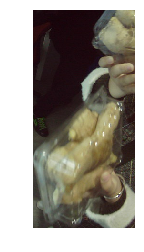

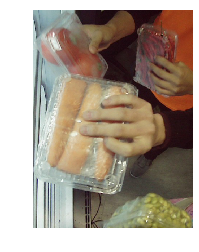

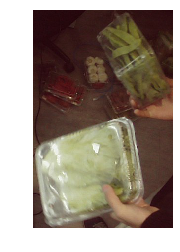

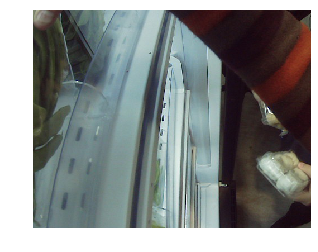

In [252]:
show_image()

In [6]:
def default_loader(path):
    return Image.open(path).convert('RGB')

# 图片的地址
jpg_name = '/home/zufall/sucai_label/VOCdevkit/VOC2018-2/JPEGImages/{}.jpg'
# 所有需要训练的图片名字列表
txt_file = 'Main/{}.txt'
# 存放crop尺寸，label的txt文件
txt_name = 'labels/{}.txt'
CLASSES = 25

class MyImageFolder(Dataset):
    def __init__(self, txt_file, transform=None, loader=default_loader):
        with open(txt_file, 'r') as f:
            self.files = [i.strip() for i in f.readlines()]
        self.transform = transform
        self.loader = loader

    def __getitem__(self, index):
        img_name = jpg_name.format(self.files[index])
        img = self.loader(img_name)
        size, label = self.load_txt(txt_name.format(self.files[index]))
        img = img.crop([size[0], size[1], size[2], size[3]])
        if self.transform is not None:
            img = self.transform(img)
            
        # one hot encoding 
        y = torch.LongTensor([label])
        y_onehot = torch.FloatTensor(1, CLASSES)
        y_onehot.zero_()
        y_onehot.scatter_(1, y, 1)
        
        return img, y_onehot.squeeze()
    
    def load_txt(self, txt_name):
        with open(txt_name) as txt:
            file = [i.strip().split() for i in txt.readlines()] 
            all_file = list(map(int, file[0]))
            size = all_file[:4]
            label = all_file[4:]
        
        return size, label

    def __len__(self):
        return len(self.files)

In [7]:
with open(glob.glob('labels/*')[0]) as txt:
    file = [i.strip().split() for i in txt.readlines()] 
    all_file = list(map(int, file[0]))
    size = all_file[:4]
    label = all_file[4:]
    print(size)
    print(label)
#     print(all_file)

[820, 233, 1095, 627]
[19, 16]


In [8]:
def create_dataset(txt_file = '{}',
                   phase = ['train', 'val'],
                   shuffle=True,
                   img_size=224,
                   batch_size=32):

    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        'val': transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    }

    image_datasets = {}
    dataloaders = {}
    dataset_sizes = {}
    for x in phase:    # ['train', 'val']
        image_datasets[x] = MyImageFolder(txt_file.format(x),
                                          data_transforms[x])
        if x == 'train':
            dataloaders[x] = DataLoader(image_datasets[x],
                                        batch_size=batch_size,
                                        shuffle=shuffle,
                                        num_workers=3)
        else:
            dataloaders[x] = DataLoader(image_datasets[x],
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=3)
        dataset_sizes[x] = len(image_datasets[x])

    out = {'image_datasets': image_datasets,
           'dataloaders': dataloaders,
           'dataset_sizes': dataset_sizes}
    return out

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = torchvision.models.resnet18()
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, CLASSES)
resnet18 = resnet18.to(device)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

data = create_dataset(txt_file, batch_size=64)
dataloaders = data['dataloaders']
dataset_sizes = data['dataset_sizes']

In [33]:
def cal_accuracy(output, target):
    inter = target[output == 1].sum()
    outer = output.sum() + target.sum() - inter

    return inter, outer

In [34]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            running_all = 0
            batch_num = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    pre = torch.sigmoid(outputs) > 0.5
                    

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        
                        if batch_num%200 == 0:
                            print("batch: {} loss: {}".format(batch_num, loss.item()))
                        batch_num += 1

                # statistics
                running_loss += loss.item() * inputs.size(0)
                corrects, all_ = cal_accuracy(pre.float(), labels)
                running_corrects += corrects
                running_all += all_

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.float() / running_all

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(best_model_wts, 'model_new.pkl')

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model
    

In [35]:
train_model(model=resnet18, criterion=criterion, optimizer=optimizer, scheduler=exp_lr_scheduler)

Epoch 0/24
----------
batch: 0 loss: 0.7259067893028259
batch: 200 loss: 0.254195898771286
batch: 400 loss: 0.21827639639377594
train Loss: 0.2464 Acc: 0.0803
val Loss: 0.2042 Acc: 0.2477

Epoch 1/24
----------
batch: 0 loss: 0.20352663099765778
batch: 200 loss: 0.17522147297859192
batch: 400 loss: 0.17796404659748077
train Loss: 0.1839 Acc: 0.2767
val Loss: 0.1564 Acc: 0.3970

Epoch 2/24
----------
batch: 0 loss: 0.1534470021724701
batch: 200 loss: 0.14059382677078247
batch: 400 loss: 0.12206269800662994
train Loss: 0.1310 Acc: 0.4804
val Loss: 0.1273 Acc: 0.4953

Epoch 3/24
----------
batch: 0 loss: 0.1248297318816185
batch: 200 loss: 0.07238087058067322
batch: 400 loss: 0.07592464983463287
train Loss: 0.0907 Acc: 0.6395
val Loss: 0.0804 Acc: 0.6875

Epoch 4/24
----------
batch: 0 loss: 0.10070549696683884
batch: 200 loss: 0.05014444887638092
batch: 400 loss: 0.060112856328487396
train Loss: 0.0641 Acc: 0.7459
val Loss: 0.0579 Acc: 0.7680

Epoch 5/24
----------
batch: 0 loss: 0.04720

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [59]:
resnet18.load_state_dict(torch.load('model.pkl'))

In [60]:
with open('Main/val.txt', 'r') as f:
    ids = f.readlines()
resnet18 = resnet18.to(device)
resnet18.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [61]:
def test(ids=ids):
    for id in ids[5:10]:
        start = time.time()
        id = id.strip()
        image = '../VOCdevkit/VOC2018-2/JPEGImages/{}.jpg'.format(id)
        image_xml = '../VOCdevkit/VOC2018-2/Annotations/{}.xml'.format(id)
        size, label = parse_rec(image_xml)
        image1 = Image.open(image).convert("RGB")
        image_size = image1.crop([size[0], size[1], size[2], size[3]])
        plt.figure()
        plt.imshow(image1)
        plt.axis('off')
        plt.figure()
        plt.imshow(image_size)
        plt.axis('off')
        plt.show()
        
        imsize = 224
        loader = transforms.Compose([transforms.Resize((imsize, imsize)),
                                     transforms.ToTensor(), 
                                     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
        image2 = loader(image_size).float()
        image2 = image2.unsqueeze(0).to(device)
        
        output = torch.sigmoid(resnet18(image2))
        output = output > 0.5
        end = time.time()
        time_elapsed = end - start
        print(time_elapsed)
        print('Testing complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
        mask = np.equal(output.cpu().numpy(), 1).squeeze()
        names_array = np.array(names)
        print(names_array[mask])
    

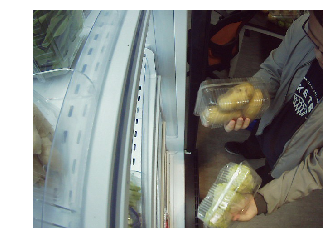

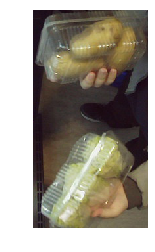

0.16434001922607422
Testing complete in 0m 0s
['tudou' 'shengcai']


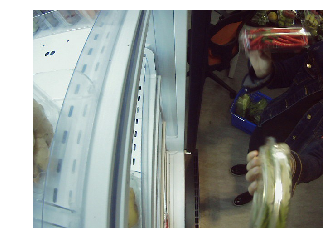

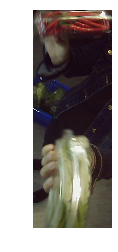

0.15680885314941406
Testing complete in 0m 0s
['xiaomijiao' 'cong']


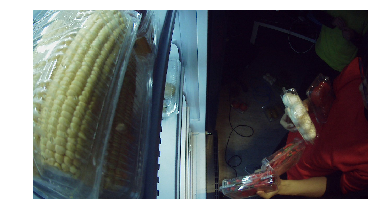

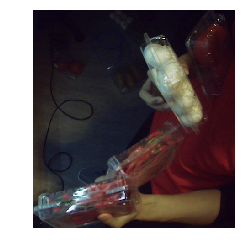

0.20346832275390625
Testing complete in 0m 0s
['xiaomijiao' 'dasuantou' 'xihongshi']


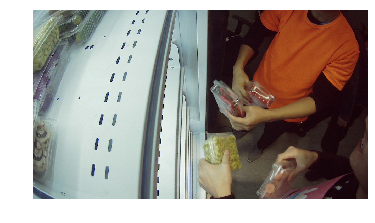

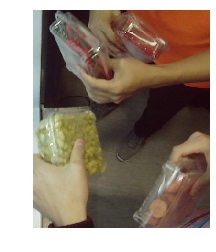

0.193115234375
Testing complete in 0m 0s
['maodou' 'xiaomijiao' 'xihongshi' 'huluobo']


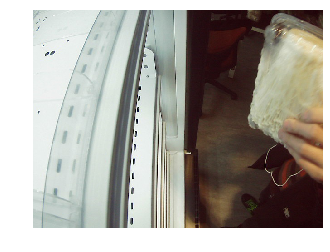

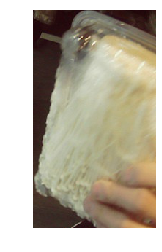

0.16008377075195312
Testing complete in 0m 0s
['jinzhengu']


In [62]:
test()

In [82]:
output = resnet18(image)
output = torch.sigmoid(output)
pre = output > 0.5
print(pre)
print(label)
a, b = cal_accuracy(pre, label)
print(a)
print(b)
# print((label == pre).float().mean())

TypeError: conv2d(): argument 'input' (position 1) must be Tensor, not str

In [ ]:
from torch import optim
model = nn.Linear(20, 5) # predict logits for 5 classes
x = torch.randn(1, 20)
y = torch.tensor([[1., 0., 1., 0., 0.]]) # get classA and classC as active

criterion1 = nn.BCEWithLogitsLoss()
criterion2 = nn.BCELoss()

output1 = criterion1(model(x), y)
output2 = criterion2(torch.sigmoid(model(x)), y)
criterion3 = nn.MultiLabelSoftMarginLoss(model(x), y)
print(output1)
print(output2)

optimizer = optim.SGD(model.parameters(), lr=1e-1)

for epoch in range(20):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    print('Loss: {:.3f}'.format(loss.item()))